# Lectura de los datos

# Librerias necesarias

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
plt.style.use('ggplot')

Se leen los datos de la agrupación total que contiene:

- n° de inscritos
- n° de admitidos
- n° de graduados

In [2]:
ruta = "/home/daniel/OneDrive/Documentos (OneDrive-UNAL)/pro_inv/Proyecto-de-Investigacion/Analisis_Marzo/BD_agrupada.xlsx"

df0 = pd.read_excel(ruta)
df0['ano'] = df0['ano'].astype("category")

Antes de analizar los datos, necesitamos observar que el conteo a utilizar como variable de respuesta $Y$ cumplan con el supuesto que la media (nuestro parametro $\lambda$) sea constante, es decir que los valores varien frente a una valor

In [3]:
# Columnas a cosiderar
v = list()
for i in [0,1,2,3,5,6,7,8,9]:
    v.append(list(df0.columns.values)[i])

# Nueva BD agrupando por nyear
df = df0[v].groupby(['ano', 'sector_ies', 'sexo', 'area_de_conocimiento'], as_index=False)[v[6:9]].agg(np.sum)

Una vez se agruparon los datos por las variables pertinetes tenemos que nuestra nueva BD es:

In [4]:
df.head(5)

,ano,sector_ies,sexo,area_de_conocimiento,demanda_real,admitidos,demanda_potencial
0,2007,oficial,femenino,agronomia veterinaria afines,6388,2371,706
1,2007,oficial,femenino,bellas artes,6425,1392,399
2,2007,oficial,femenino,ciencias educacion,32780,16150,4832
3,2007,oficial,femenino,ciencias salud,55169,6975,2982
4,2007,oficial,femenino,ciencias sociales humanas,42506,12549,4073


Ahora se precede a graficar los datos del conteo de la variable de respuesta (demanda potencial) por algún tipo de varible a agrupar, en este caso se toma por sexo según el caracter de la IES.

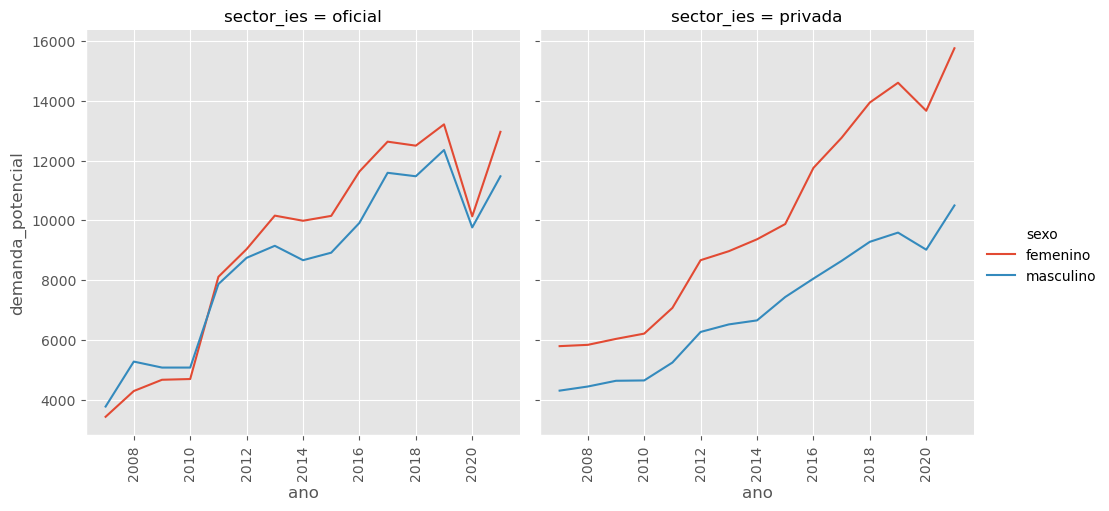

In [5]:
# Serie de tiempo de los datos de Demanda potencial
ax = sns.relplot(kind='line', data=df, x = 'ano', y = 'demanda_potencial', hue='sexo',col='sector_ies', errorbar=None)
ax.tick_params(axis='x', rotation=90)
plt.show()

Se puede notar que en los dos casos ninguno cuenta con media constante.

# Partición de los datos

se crean los datos de entramiento y test de los datos, teniendo en cuenta que estos se parten de forma secuencial, se toma el 80% de los datos de arriba hacia abajo dejando el 20% al conjunto de testeo.


In [6]:
df_train = df.iloc[0:384,:]
df_test = df.iloc[384:480,:]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=384
Testing data set length=96


Ahora creamos la formula para aplicar al modelo:

In [7]:
expr = "demanda_potencial~ano+sector_ies+sexo+area_de_conocimiento+demanda_real+admitidos"

# One-hot encoding
y_train, X_train = dmatrices(expr, df_train,return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Se ajusta el modelo con las matrices de diseño creadas:

In [8]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      demanda_potencial   No. Observations:                  384
Model:                            GLM   Df Residuals:                      361
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1207e+05
Date:                Mon, 03 Apr 2023   Deviance:                   2.2024e+05
Time:                        17:49:47   Pearson chi2:                 2.23e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

# Predicciones

In [9]:
poisson_predictions = poisson_training_results.get_prediction(X_test)

poisson_predictions2 = poisson_training_results.get_prediction(X_train)

#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

rmse_test = np.sqrt(np.sum((poisson_predictions.predicted_mean-y_test.demanda_potencial.to_numpy())**2)/192)

print("RMSE de test: ",rmse_test)

rmse_train = np.sqrt(np.sum((poisson_predictions2.predicted_mean-y_train.demanda_potencial.to_numpy())**2)/768)

print("RMSE de train: ",rmse_train)

print("Error de Predicción: ",rmse_train-rmse_test)

print(predictions_summary_frame)

RMSE de test:  6542.811493441338
RMSE de train:  1453.3195655737834
Error de Predicción:  -5089.491927867554
             mean    mean_se  mean_ci_lower  mean_ci_upper
384   1287.360892   6.184573    1275.296240    1299.539680
385   2149.542340   8.724712    2132.510056    2166.710660
386   4336.233690  15.004576    4306.924761    4365.742069
387   4160.036441  14.425793    4131.858272    4188.406777
388   7334.880902  23.297815    7289.359866    7380.686211
..            ...        ...            ...            ...
475   3555.573417  12.489072    3531.179351    3580.136002
476   7206.181735  22.797104    7161.638468    7251.002048
477  13463.009286  42.819470   13379.345704   13547.196031
478  15002.050470  56.074701   14892.547672   15112.358426
479    672.141019   3.583117     665.154800     679.200616

[96 rows x 4 columns]


## Verificación de los valores reales vs los predichos

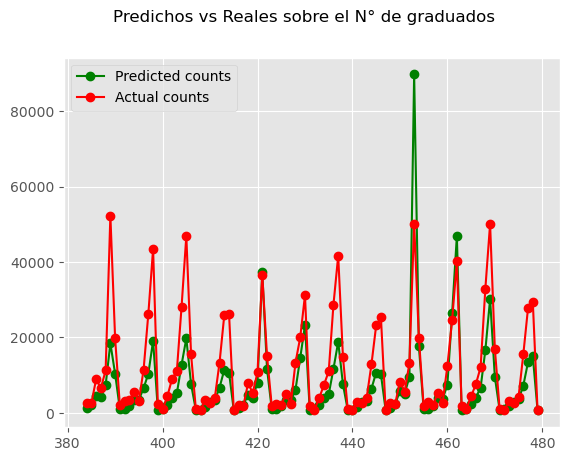

In [10]:
#Mlot the predicted counts versus the actual counts for the test data.
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['demanda_potencial']
fig = plt.figure()
fig.suptitle('Predichos vs Reales sobre el N° de graduados')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

## Grafico de puntos reales vs predichos

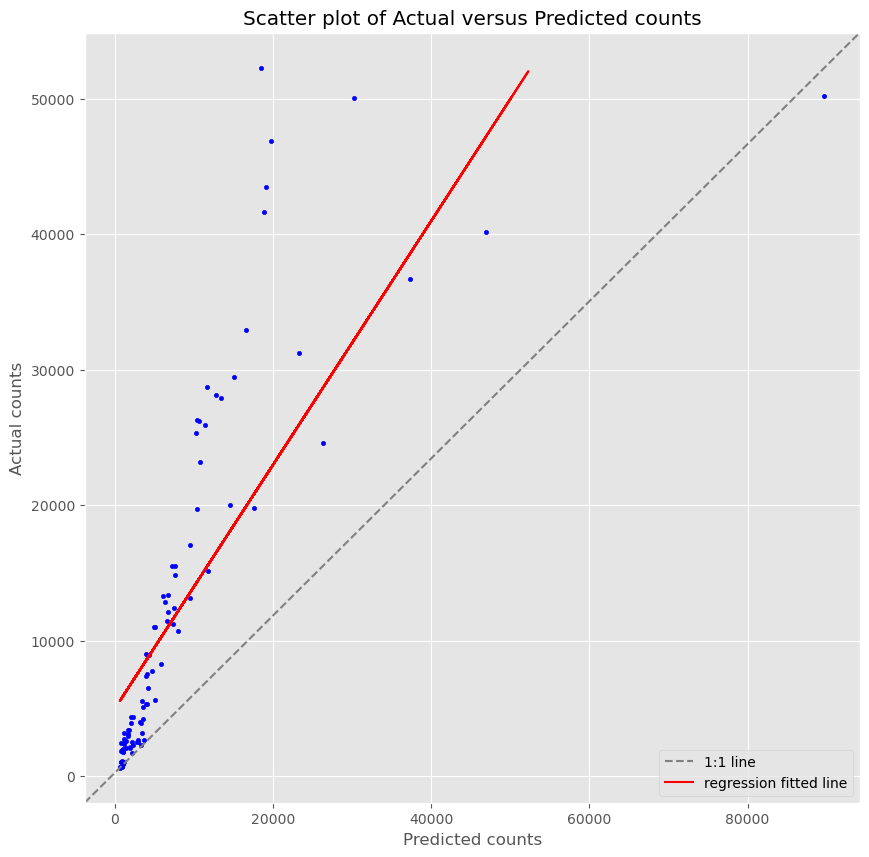

In [18]:
# Linear regression
m, b = np.polyfit(predicted_counts,actual_counts, 1)
#Show scatter plot of Actual versus Predicted counts
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=predicted_counts, y=actual_counts, marker='.', color = "blue")
ax.plot((0, 1), (0, 1), color = "gray", transform=ax.transAxes, ls = '--', label="1:1 line")
ax.plot(actual_counts, m*actual_counts+b, color = "red", label = "regression fitted line")
ax.set(ylabel ="Actual counts", xlabel = "Predicted counts",
       title="Scatter plot of Actual versus Predicted counts")
plt.legend()
plt.show()